# MAGICC7

Pymagicc is also MAGICC7 compatible. 

As yet, the binary is not yet publicly available to it's a bit fiddlier to get setup. Here we give a minimal working example of how to use MAGICC7 with Pymagicc.

Temporary notes:

- fix handling of climate_model, model and scenario names for rcps
- fix handling of climate_model, model and scenario names when input has those columns already (and "unspecified" to check of whether to overwrite or not)
- make append be able to handle MAGICCData too

In [10]:
# NBVAL_IGNORE_OUTPUT

import pandas as pd
import pymagicc
from pymagicc import MAGICC6, MAGICC7
from pymagicc.io import MAGICCData

from pymagicc import rcp26, rcp45, rcp60, rcp85, scenarios

In [11]:
# NBVAL_IGNORE_OUTPUT
%matplotlib inline
from matplotlib import pyplot as plt
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = 16, 9

In [12]:
# set your environment to find your MAGICC binary
%env MAGICC_EXECUTABLE_7=../../magicc/run/magicc

env: MAGICC_EXECUTABLE_7=../../magicc/run/magicc


## The slow, easy way

Use the `pymagicc.run` API. This is super slow as it makes a new copy of the entire `magicc/run` directory for each run.

A few common issues when using your own setup are:
    - output flag settings may mean that you don't get the output you expect
    - super slow running as lots of output are being read back in (turn `OUT_XX` flags off to speed things up)
    - super slow running as your `out` directory is not empty before you run
    - your config file has more than one emissions scenario and/or config flag set (Pymagicc deliberately throws an error here to avoid difficult debugging of overlapping emissions and config inputs)
    
`MAGCFG_USER.CFG` should have lines like

```FORTRAN90
  FILE_EMISSCEN =  "NONE",
  FILE_EMISSCEN_2 =  "",
  FILE_EMISSCEN_3 =  "",
  FILE_EMISSCEN_4 =  "",
  FILE_EMISSCEN_5 =  "",
  FILE_EMISSCEN_6 =  "",
  FILE_EMISSCEN_7 =  "",
  FILE_EMISSCEN_8 =  "",
  FILE_TUNINGMODEL_1 =  "PYMAGICC",
  FILE_TUNINGMODEL_2 =  "USER",
  FILE_TUNINGMODEL_3 =  "USER",
  FILE_TUNINGMODEL_4 =  "USER",
  FILE_TUNINGMODEL_5 =  "USER",
  FILE_TUNINGMODEL_6 =  "USER",
  FILE_TUNINGMODEL_7 =  "USER",
  FILE_TUNINGMODEL_8 =  "USER",
  FILE_TUNINGMODEL_9 =  "USER",
  FILE_TUNINGMODEL_10 =  "USER",
```

In [14]:
scen.head()

,variable,todo,unit,region,climate_model,model,scenario,time,value
392,Emissions|BC,SET,Mt BC / yr,World,unspecified,unspecified,unspecified,2000-07-12 00:00:00,7.8048
392,Emissions|BC,SET,Mt BC / yr,World|Bunkers,unspecified,unspecified,unspecified,2000-07-12 00:00:00,0.1361
392,Emissions|BC,SET,Mt BC / yr,World|R5ASIA,unspecified,unspecified,unspecified,2000-07-12 00:00:00,3.0468
392,Emissions|BC,SET,Mt BC / yr,World|R5LAM,unspecified,unspecified,unspecified,2000-07-12 00:00:00,0.9311
392,Emissions|BC,SET,Mt BC / yr,World|R5MAF,unspecified,unspecified,unspecified,2000-07-12 00:00:00,1.8766


In [15]:
name

'RCP45'

In [16]:
try:
    del results
except NameError:
    pass
for name, scen in scenarios.items():
    print("running {}".format(name))
    scen = MAGICCData(scen.data, scenario=name)
    scen_results = pymagicc.run(scen, magicc_version=7)
    try:
        results.append(scen_results)
        break
    except NameError:
        results = scen_results
#     surface_temp = results.filter(
#         variable="Surface Temperature",
#         region="World"
#     ).line_plot(x="time")
#     results_df.set_index("time", inplace=True)    

#     global_temp_time_rows = (
#         (results_df.variable == "Surface Temperature")
#         & (results_df.region == "World")
#     )
    
#     temp = (
#         results_df.value[global_temp_time_rows].loc[1850:]
#         - results_df.value[global_temp_time_rows].loc[1850:1900].mean()
#     )
#     surface_temp.plot(x="time", y="value", label=name)
    
# plt.legend()
# plt.title("Global Mean Temperature Projection")
# plt.ylabel("°C over pre-industrial (1850-1900 mean)");

running RCP26
running RCP45


In [17]:
results.head()

,model,scenario,region,variable,unit,time,climate_model,todo,value
0,unspecified,RCP26,World,Atmospheric Concentrations|CH4,ppb,1765-07-12,MAGICC7,N/A,739.40856
1,unspecified,RCP26,World|Northern Hemisphere|Land,Atmospheric Concentrations|CH4,ppb,1765-07-12,MAGICC7,N/A,759.19697
2,unspecified,RCP26,World|Northern Hemisphere|Ocean,Atmospheric Concentrations|CH4,ppb,1765-07-12,MAGICC7,N/A,759.19697
3,unspecified,RCP26,World|Southern Hemisphere|Land,Atmospheric Concentrations|CH4,ppb,1765-07-12,MAGICC7,N/A,719.62015
4,unspecified,RCP26,World|Southern Hemisphere|Ocean,Atmospheric Concentrations|CH4,ppb,1765-07-12,MAGICC7,N/A,719.62015


In [18]:
results.meta

exclude
model       scenario         
unspecified RCP26       False
            RCP45       False

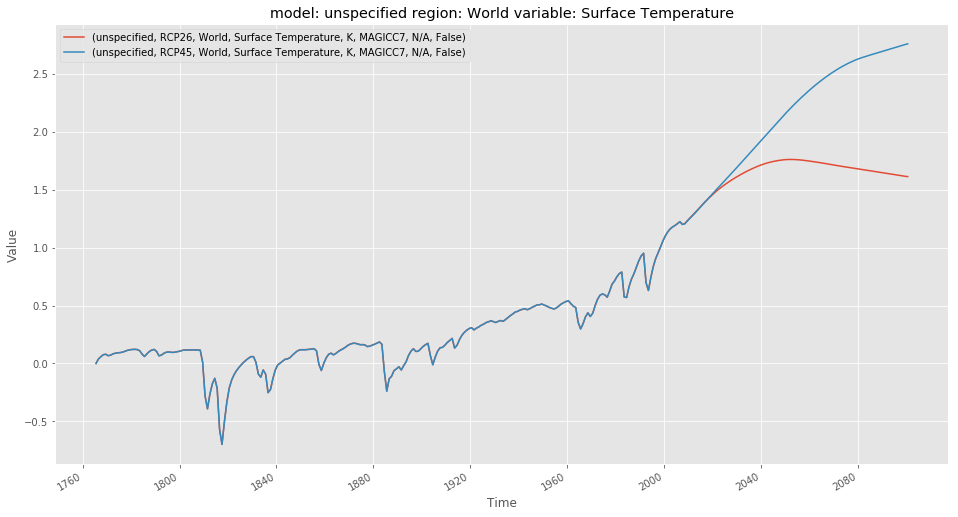

In [20]:
results.filter(
    variable="Surface Temperature",
    region="World"
).line_plot(x="time")

## The faster, mildly more difficult way

Use the context manager for the MAGICC version we want. This still creates a copy of the entire run folder, but only once.

In [ ]:
with MAGICC7() as magicc:
    for name, scen in scenarios.items():
        # note that we obviously don't need magicc_version as an argument 
        # here
        results = magicc.run(scen, out_temperature=1)
        results_df = results.df
        results_df.set_index("time", inplace=True)    

        global_temp_time_rows = (
            (results_df.variable == "Surface Temperature")
            & (results_df.region == "World")
        )

        temp = (
            results_df.value[global_temp_time_rows].loc[1850:]
            - results_df.value[global_temp_time_rows].loc[1850:1900].mean()
        )
        temp.plot(label=name)

plt.legend()
plt.title("Global Mean Temperature Projection")
plt.ylabel("°C over pre-industrial (1850-1900 mean)");

## The even faster, more dangerous and difficult to debug way

Use the context manager for the MAGICC version we want and specify the root directory. This doesn't create a copy of the entire run folder, but will modify files in place and blow up if any of your settings are not correct.

Common gotchas:

- not clearing `out` directory before running so things are super slow
- pre-existing `MAGTUNE_PYMAGICC.CFG` file with config you don't want to use, or which you want to overwrite (we currently don't do any overwriting with Pymagicc)

In [ ]:
with MAGICC7(root_dir="../../magicc") as magicc:
    # binary readers aren't yet ready and we can't do this through
    # the run method just yet
    magicc.set_output_variables(
        write_ascii=True, write_binary=False, 
        temperature=True, emissions=True,
        parameters=True
    )  
    for name, scen in scenarios.items():
        results = magicc.run(scen)
        results.df = results.df.copy()
        results.df.set_index("time", inplace=True)    

        global_temp_time_rows = (
            (results.df.variable == "Surface Temperature")
            & (results.df.region == "World")
        )

        temp = (
            results.df.value[global_temp_time_rows].loc[1850:]
            - results.df.value[global_temp_time_rows].loc[1850:1900].mean()
        )
        temp.plot(label=name)

plt.legend()
plt.title("Global Mean Temperature Projection")
plt.ylabel("°C over pre-industrial (1850-1900 mean)");

## Comparing MAGICC6 and MAGICC7

Finally, we show how to easily compare MAGICC6 and MAGICC7.

In [ ]:
magicc7_results = []
with MAGICC7(root_dir="../../magicc") as magicc:
    # binary readers aren't yet ready and we can't do this through
    # the run method just yet
    magicc.set_output_variables(
        write_ascii=True, write_binary=False, 
        temperature=True, emissions=True,
        parameters=True
    )  
    for name, scen in scenarios.items():
        results = magicc.run(scen)
        results.df["Climate Model"] = "MAGICC7"
        results.df["Scenario"] = name
        magicc7_results.append(results.df)
        
magicc7_results = pd.concat(magicc7_results)

In [ ]:
magicc6_results = []
with MAGICC6() as magicc:
    #########################################################
    # this doesn't work with MAGICC6 as the flag set is wrong
#     magicc.set_output_variables(
#         write_ascii=True, write_binary=False, 
#         temperature=True, emissions=True,
#         parameters=True
#     )  
    #########################################################
    for name, scen in scenarios.items():
        results = magicc.run(scen, endyear=2500)
        results.df["Climate Model"] = "MAGICC6"
        results.df["Scenario"] = name
        magicc6_results.append(results.df)

magicc6_results = pd.concat(magicc6_results)

In [ ]:
results = pd.concat([magicc6_results, magicc7_results])

In [ ]:
results.head()

In [ ]:
plt.figure(figsize=(16, 9))
for label, df in results.groupby(["Climate Model", "Scenario"]):
    df.set_index("time", inplace=True)    

    global_temp_time_rows = (
        (df.variable == "Surface Temperature")
        & (df.region == "World")
    )

    temp = (
        df.value[global_temp_time_rows].loc[1850:]
        - df.value[global_temp_time_rows].loc[1850:1900].mean()
    )
    temp.plot(label=label)

plt.legend()
plt.title("Global Mean Temperature Projection")
plt.ylabel("°C over pre-industrial (1850-1900 mean)");